# Udacity Data Engineering Capstone

# Table of contents
1. [Imports](#imports)
2. [Step 1: Project Scope and Data Gathering](#step1)
    * [Scope](#scope)
    * [Data Description](#data_desc)
3. [Step 2: Data Exploration & Modeling](#step2)
4. [Step 3: Define the Data Model](#step3)
    * [3.1 Conceptual Data Model](#data_model)
    * [3.2 Mapping Out Data Pipelines](#pipeline_steps)
5. [Step 4: Run Pipelines to Model the Data](#step4)
6. [Step 5: Complete Project Write Up](#step5)

## Imports <a name="imports"></a>

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, rand
from pyspark.sql.functions import isnan, when, count, col

In [5]:
import configparser
import psycopg2

## Step 1: Project Scope and Data Gathering <a name="step1"></a>

### Scope <a name="scope"></a>

For my capstone project I developed a data pipeline that creates an analytics database for querying information about immigration into the U.S. The analytics tables are hosted in a Redshift Database and the pipeline implementation was done using Apache Airflow.

### Data Description <a name="data_desc"></a>

The following datasets were used to create the analytics database:
* I94 Immigration Data: This data comes from the US National Tourism and Trade Office found [here](https://travel.trade.gov/research/reports/i94/historical/2016.html). Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
* World Temperature Data: This dataset came from Kaggle found [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
* U.S. City Demographic Data: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
* Airport Code Table: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from [here](https://datahub.io/core/airport-codes#data).

#### I94 Immigration Data pull

In [6]:
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [7]:
imm_data = spark.read.parquet("sas_data")
print(imm_data.count())
imm_data.limit(10).toPandas()

3096313


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,...,None,M,1959.0,10292016,M,None,NZ,9.498180e+10,00010,B2
6,5748523.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1950.0,10292016,F,None,NZ,9.497969e+10,00010,B2
7,5748524.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1975.0,10292016,F,None,NZ,9.497975e+10,00010,B2
8,5748525.0,2016.0,4.0,245.0,464.0,HOU,20574.0,1.0,FL,20581.0,...,None,M,1989.0,10292016,M,None,NZ,9.497325e+10,00028,B2
9,5748526.0,2016.0,4.0,245.0,464.0,LOS,20574.0,1.0,CA,20581.0,...,None,M,1990.0,10292016,F,None,NZ,9.501355e+10,00002,B2


#### U.S. City Demographic Data pull

In [8]:
city_dem_data = pd.read_csv('data/us-cities-demographics.csv', sep=';')
print(city_dem_data.info())
city_dem_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    2891 non-null   object 
 1   State                   2891 non-null   object 
 2   Median Age              2891 non-null   float64
 3   Male Population         2888 non-null   float64
 4   Female Population       2888 non-null   float64
 5   Total Population        2891 non-null   int64  
 6   Number of Veterans      2878 non-null   float64
 7   Foreign-born            2878 non-null   float64
 8   Average Household Size  2875 non-null   float64
 9   State Code              2891 non-null   object 
 10  Race                    2891 non-null   object 
 11  Count                   2891 non-null   int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 271.2+ KB
None


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Airport Code Data

In [9]:
airport_code_data = pd.read_csv('data/airport-codes_csv.csv')
print(airport_code_data.info())
airport_code_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         55075 non-null  object 
 1   type          55075 non-null  object 
 2   name          55075 non-null  object 
 3   elevation_ft  48069 non-null  float64
 4   continent     27356 non-null  object 
 5   iso_country   54828 non-null  object 
 6   iso_region    55075 non-null  object 
 7   municipality  49399 non-null  object 
 8   gps_code      41030 non-null  object 
 9   iata_code     9189 non-null   object 
 10  local_code    28686 non-null  object 
 11  coordinates   55075 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.0+ MB
None


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### World Temperature Data

In [10]:
temp_data = pd.read_csv('data/GlobalLandTemperaturesByCity.csv')
print(temp_data.info())
temp_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


## Step 2: Data Exploration & Modeling <a name="step2"></a>

### Data Prep

In [34]:
def sas_program_file_value_parser(sas_source_file, value, columns):
    """Parses SAS Program file to return value as pandas dataframe
    Args:
        sas_source_file (str): SAS source code file.
        value (str): sas value to extract.
        columns (list): list of 2 containing column names.
    Return:
        None
    """
    file_string = ''
    
    with open(sas_source_file) as f:
        file_string = f.read()
    
    file_string = file_string[file_string.index(value):]
    file_string = file_string[:file_string.index(';')]
    
    line_list = file_string.split('\n')[1:]
    codes = []
    values = []
    
    for line in line_list:
        
        if '=' in line:
            code, val = line.split('=')
            code = code.strip()
            val = val.strip()

            if code[0] == "'":
                code = code[1:-1]

            if val[0] == "'":
                val = val[1:-1]

            codes.append(code)
            values.append(val)
        
            
    return pd.DataFrame(zip(codes,values), columns=columns)

In [35]:
i94cit_res = sas_program_file_value_parser('data/I94_SAS_Labels_Descriptions.SAS', 'i94cntyl', ['code', 'country'])
i94cit_res.head()

,code,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [36]:
i94port = sas_program_file_value_parser('data/I94_SAS_Labels_Descriptions.SAS', 'i94prtl', ['code', 'port'])
i94port.head()

,code,port
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [37]:
i94mode = sas_program_file_value_parser('data/I94_SAS_Labels_Descriptions.SAS', 'i94model', ['code', 'mode'])
i94mode.head()

,code,mode
0,1,Air
1,2,Sea
2,3,Land
3,9,Not reported


In [38]:
i94addr = sas_program_file_value_parser('data/I94_SAS_Labels_Descriptions.SAS', 'i94addrl', ['code', 'addr'])
i94addr.head()

,code,addr
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [39]:
i94visa = sas_program_file_value_parser('data/I94_SAS_Labels_Descriptions.SAS', 'I94VISA', ['code', 'type'])
i94visa.head()

,code,type
0,1,Business
1,2,Pleasure
2,3,Student


#### I94 Immigration Data prep

In [18]:
imm_data.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [20]:
imm_data.limit(10).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1
5,5748522.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20579.0,...,None,M,1959.0,10292016,M,None,NZ,9.498180e+10,00010,B2
6,5748523.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1950.0,10292016,F,None,NZ,9.497969e+10,00010,B2
7,5748524.0,2016.0,4.0,245.0,464.0,HHW,20574.0,1.0,HI,20586.0,...,None,M,1975.0,10292016,F,None,NZ,9.497975e+10,00010,B2
8,5748525.0,2016.0,4.0,245.0,464.0,HOU,20574.0,1.0,FL,20581.0,...,None,M,1989.0,10292016,M,None,NZ,9.497325e+10,00028,B2
9,5748526.0,2016.0,4.0,245.0,464.0,LOS,20574.0,1.0,CA,20581.0,...,None,M,1990.0,10292016,F,None,NZ,9.501355e+10,00002,B2


In [56]:
## immigration
imm_data_cit_res_df = imm_data.select('i94cit', 'i94res').toPandas()
print(imm_data_cit_res_df.head())

   i94cit  i94res
0   245.0   438.0
1   245.0   438.0
2   245.0   438.0
3   245.0   438.0
4   245.0   438.0


In [57]:
i94cit_res['code'] = i94cit_res['code'].astype(int)
i94cit_res_dict = i94cit_res.set_index('code').to_dict()['country']

In [58]:
imm_data_cit_res_df[['i94cit', 'i94res']] = imm_data_cit_res_df[['i94cit', 'i94res']].astype(int)
imm_data_cit_res_df['i94cit'] = imm_data_cit_res_df['i94cit'].apply(lambda x: i94cit_res_dict[x] if x in i94cit_res_dict else None)
imm_data_cit_res_df['i94res'] = imm_data_cit_res_df['i94res'].apply(lambda x: i94cit_res_dict[x] if x in i94cit_res_dict else None)
imm_data_cit_res_df.head()

,i94cit,i94res
0,"CHINA, PRC",AUSTRALIA
1,"CHINA, PRC",AUSTRALIA
2,"CHINA, PRC",AUSTRALIA
3,"CHINA, PRC",AUSTRALIA
4,"CHINA, PRC",AUSTRALIA


In [63]:
i94_cits_count = imm_data_cit_res_df['i94cit'].value_counts().reset_index().rename(columns={'i94cit': 'count', 'index': 'i94cit'})
i94_res_count = imm_data_cit_res_df['i94res'].value_counts().reset_index().rename(columns={'i94res': 'count', 'index': 'i94res'})


In [77]:
popular_cit = i94_cits_count.head(20)
popular_res = i94_res_count.head(20)

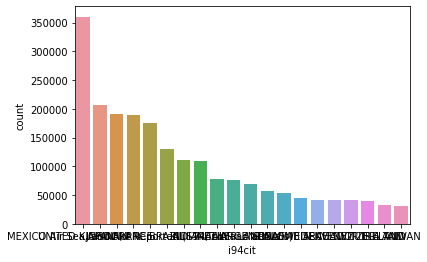

In [78]:
sns.barplot(x='i94cit', y='count', data=popular_cit)

## Step 3: Define the Data Model <a name="step3"></a>

### 3.1 Conceptual Data Model <a name="data_model"></a>

Map out the conceptual data model and explain why you chose that model

<img src="README_IMGS/ERD.jpg"/>

### 3.2 Mapping Out Data Pipelines <a name="pipeline_steps"></a>

Steps necessary to pipeline the data into the chosen data model:


    >> Begin Dummy Operator.

        >> Operator extract tables from I94 labels mappings files and stage to S3/local as csv:
            * i94cit_res
            * i94port
            * i94mode
            * i94addr
            * i94visa   
            >> Copy the above csv files from local/s3 to create tables in Redshift.
                >> Perform data quality checks for the tables above.
            >> Transform immigration data files on local/s3 and write results to `immigration` Redshift table.
                >> Perform data qualitiy checks for immigration table

        >> Copy csv files from local/s3 to create the following tables in Redshift.
            * us_cities_demographics
            * airport_codes
            * world_temperature
            >> Perform data quality checks on above tables.
            
                >> End Dummy Operator.
  

<img src="README_IMGS/dag.png"/>

## Step 4: Run Pipelines to Model the Data <a name="step4"></a>

### 4.1 Create the data model

Build the data pipelines to create the data model.

Create Tables:
```bash
(venv) $ python create_tables.py
```

Launch Airflow UI:
1. Initialize Airflow & Run Webserver
```bash
(venv) $ export AIRFLOW_HOME=$(pwd)
(venv) $ airflow initdb
(venv) $ airflow webserver -p 8080
```
2. Run Scheduler (Open New Terminal Tab)
```bash
(venv) $ export AIRFLOW_HOME=$(pwd)
(venv) $ airflow scheduler
```
3. Access Airflow UI at `localhost:8080`
4. Run `etl_dag` in Airflow UI

## Step 5: Complete Project Write Up <a name="step5"></a>

### Technology Choices and tools

* Clearly state the rationale for the choice of tools and technologies for the project.

1. Apache Airflow: Allows for easy scheduling and monitoring etl workflows for keeping analytics database up to date
2. Redshift: For storing analytics tables in a distributed manner

### Data Schedule Proposal

* Propose how often the data should be updated and why.

Pipeline will be scheduled monthly as immigration data is the primary datasource is on a monthly granularity

### Possible Scenerios, changes and approach

* Write a description of how you would approach the problem differently under the following scenarios:-

 * **The data was increased by 100x:** Will have to use partitioning functionality in the dag, might also need to use Cloud services like AWS EMR to use spark for processing data.
 
 * **The data populates a dashboard that must be updated on a daily basis by 7am every day:** Will need to update the schedule of the DAG accordingly as make sure we have data needed for the dashboard.
 
 * **The database needed to be accessed by 100+ people:** Will create roles for the different people on AWS. That way different people have access to the relevant resources.